# Advanced Topic Modeling with BERTopic
(https://zoumanakeita.medium.com/)

This notebook contains all the code from my article on medium [here](https://zoumanakeita.medium.com/) 

<br>

<img src="https://images.unsplash.com/photo-1612855190135-bdbacda2a2b5?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80" width="100%">

# **Installing BERTopic**

We start by installing BERTopic from PyPi:

In [1]:
%%capture
!pip install bertopic

## Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

# Data
This is the Australian Broadcasting Corporation news published over a period of eight years, freely available on [Kaggle](https://www.kaggle.com/therohk/million-headlines). It has two main columns:
publish_date: date of publishing for the article in yyyyMMdd format.
headline_text: text of the headline in English. This is the information that will be used by the topic model.

In [6]:
import pandas as pd 

In [7]:
# Github URL
data_url = "https://raw.githubusercontent.com/keitazoumana/BERTopic-Topic-Modeling/main/abcnews_sample.csv"

# Read the dataset from the URL
data = pd.read_csv(data_url)

In [8]:
data.head()

,publish_date,headline_text
0,20050627,lawyer claims aust govt has abandoned corby
1,20051206,singapore tells spouses of patients hiv status
2,20141119,iron ore price slumps to new five year low
3,20060203,youth crime prevention schemes share in funds
4,20190521,harry triguboff speaks to the business


In [9]:
# Create a new column containing the length each headline text
data["headline_text_len"] = data["headline_text"].apply(lambda x : len(x.split()))

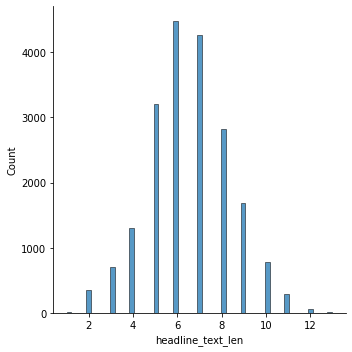

In [10]:
# Visualize the length distribution 
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data.headline_text_len, kde=False)

In [11]:
print("The longest headline has: {} words".format(data.headline_text_len.max()))

The longest headline has: 13 words


In [14]:
# Let have a look at some headline text and the longest one
for idx in data.sample(3).index:
    headline = data.iloc[idx]
    print("Headline #{}:".format(idx))
    print("Publication date: {}".format(headline.publish_date))
    print("Text: {}\n".format(headline.headline_text))

Headline #17466:
Publication date: 20080118
Text: footy charity match funds row resolved

Headline #19166:
Publication date: 20050222
Text: nsw business confidence slumps

Headline #5736:
Publication date: 20091211
Text: man to stand trial over fatal crash



# **Topic Modeling**

In this example, we will go through the main components of BERTopic and the steps necessary to create a strong topic model. 




## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead. 

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model. 


In [18]:
from bertopic import BERTopic

In [19]:
model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', 
                 min_topic_size= 50)

- Verbose to True: so that the model initiation process does not show messages.  
- paraphrase-MiniLM-L3-v2 is the sentence transformers model with the great trade-off of performance and speed. 
- min_topic_size set to 7 and the default value is 10. The higher the value, the lower is the number of cluster/topics

In [20]:
headline_topics, _ = model.fit_transform(data.headline_text)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2022-01-25 01:57:03,179 - BERTopic - Transformed documents to Embeddings
2022-01-25 01:57:24,753 - BERTopic - Reduced dimensionality with UMAP
2022-01-25 01:57:27,917 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Number of topics: 54


.fit_transform() trains the BERTopic model on the headline dataset   
Also we can see that there are 54 topics overall, but they might not be all relevant. However, we might want to look at those that best represent the collection of headlines using the .get_topic_info() function below. 

## Topic Extraction and Representation. 

In [24]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

Number of topics: 54


,Topic,Count,Name
0,-1,10165,-1_to_for_in_of
1,0,1163,0_cup_win_test_england
2,1,719,1_man_charged_murder_jailed
3,2,575,2_interview_speaks_smith_the
4,3,400,3_election_trump_party_donald


The above table has 3 main columns, providing information about all the 54 topics in descending order of topics size/Count. 
- '**Topic**' is the topic number, a kind of identifier, and the  outliers are labeled as -1. Those are topics that should be ignored because they do not bring any added value. 
- '**Count**' is the number of words in the topic.      
- **Name** is the name given to the topic.

For each topic, we can retrieve the top words and their corresponding c-TF-IDF score. The higher the score, the most relevant the word is in representing the topic.    

In [37]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('cup', 0.02967020179204242),
 ('win', 0.025689303442349282),
 ('test', 0.023607906143258146),
 ('england', 0.022776270191924724),
 ('world', 0.021061505175184816),
 ('tigers', 0.02092471758133827),
 ('australia', 0.020218680840730113),
 ('aussies', 0.01796687971641572),
 ('final', 0.017914994242164806),
 ('day', 0.015522681845085035)]

From this topic, we observe that all the words are coherent for the underlying topic which seems to be about football ⚽️.


# **Topics Visualization.**   
The topic visualization helps in gaining more insight about each topic. BERTopic provides several visualization possibilities such as terms visualization, intertopic distance map, topic hierarchy clustering just to name a few, and our focus will be on those that have been cited. 

## Topic Terms   
The most relevant words of each topic can be visualized in a form of barchart out of the c-TF-IDF score, which is interesting to visually compare topics. 
Below is the corresponding visualization for the topic 6 topics. 

In [44]:
model.visualize_barchart(top_n_topics=6)

The top words for topic 1 are man, charged murder jail over, which is obviously a crime related topic. The same analysis can be easily derived from each of the remaining topics. The longer the horizontal bar, the most relevant it is to the topic.  

## Intertopic Distance Map.   
For those who are fimiliar with Latent Dirichlet Allocation [LDAvis](https://github.com/cpsievert/LDAvis) library, if not **[here is my article about it](https://towardsdatascience.com/do-you-want-to-cluster-unlabeled-text-data-try-out-topic-modeling-235795ae7cb7)**. This library provides the user with an interactive dashboard showing for each topic the corresponding words and their score. BERTopic does the same with its visualize_topics() function and even go one step further by giving the distance between topics (the lower the most similar), and all of this with a single function **visualize_topics()**

In [46]:
model.visualize_topics()

## Visualize Topic Hierarchy
As you can see in the Interdistance topic dashboard, some topics are very close. One thing that could come to mind is how can I reduce the number of topics? The good new is that those topics can be hierarchically in order to select the appropriate number of topics. The visualization flavor helps to understand how they relate to one another. 

In [48]:
model.visualize_hierarchy(top_n_topics=30)

By looking at the first level (level 0) of the dendogram, we can see that topics with the same colors have been grouped together. For instance 
- Topic 7 (health, hospital, mental) & 14 (dies, crash, killed) have been grouped together because of their closeness.  
- Topic 6 (farmers, farm, farmer) & 16 (cattle, sheep, beef) also have be grouped the same way.  
- etc.  
All these information can help the user better understand the reason why the topics have been considered to be similar one to another. 

# **Search Topics**. 
Once the topic model is trained, we can search for topics that are semantically similar to an input query word/term using the `find_topics` function. 
In our case, we can search for top 3 topics that are related to the word 'politics'

In [69]:
# Select most 3 similar topics
similar_topics, similarity = model.find_topics("politics", top_n = 3)

- similar_topics contains the topics index from most similar to least similar.  
- similarity contains the similarity scores in descending order.  


In [70]:
similar_topics 

[3, 41, 20]

In [76]:
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('election', 0.08389822503224101), ('trump', 0.0512571921683764), ('party', 0.034052442556456154), ('donald', 0.03268734381432749), ('obama', 0.030983388040422003), ('liberal', 0.02869493503505037), ('bush', 0.022854654022153992), ('liberals', 0.022814234525823825), ('vote', 0.02273902178387999), ('presidential', 0.02256653331627359)]
Similarity Score: 0.7048206256962174


We can see that the most similar topic is showing terms 'election', 'trump', 'obama', etc. which are obviously related to politics. 

# **Model Serialization & Loading**  
When you are satisfied with your model's result, you can save if for further analysis using the following instructions:     

In [85]:
%%bash
mkdir './model_dir'

In [86]:
# Save the model in the previously created folder with the name 'my_best_model'
model.save("./model_dir/my_best_model")

# Load the serialized model
my_best_model = BERTopic.load("./model_dir/my_best_model")
my_best_model

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



# **Conclusion**
Now, you know how to use BERTopic for topic modeling. The results are very encouraging, and do not hesitate to give it a try on your business case. However, it is important to note that the results of BERTopic are not consistent between runs, this is due to the stochastic nature of UMAP used for dimensionality reduction. So, using the random_state parameter in UMAP the any stochastic behavior. 

# **Additional Ressources**   
[BERTopic Algorithm](https://maartengr.github.io/BERTopic/algorithm/algorithm.html)    
 [BERTopic FAQ](https://maartengr.github.io/BERTopic/faq.html#:~:text=Why%20are%20the%20results%20not%20consistent%20between%20runs%3F,-%C2%B6&text=Due%20to%20the%20stochastic%20nature,topics%20that%20suit%20you%20best.)  
 [BERTopic Github](https://github.com/MaartenGr/BERTopic)